In [25]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [26]:
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [27]:
fastballs = all_pitches[all_pitches['TaggedPitchType'].isin(['Fastball','Cutter','Sinker','FourSeamFastBall','TwoSeamFastBall','OneSeamFastBall'])]

In [28]:
fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_23324\409369648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)


In [29]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [30]:
fastballs_X = fastballs[preds]
fastballs_y = fastballs['whiff']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(fastballs_X, fastballs_y, test_size=.33)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.75%


In [32]:
# Get unique values
unique_values = fastballs['Pitcher'].unique()

# Create a dictionary to store subsets
subsets = {value: fastballs[fastballs['Pitcher'] == value] for value in unique_values}

In [50]:
all_preds = model.predict_proba(fastballs_X)[:,1]
mean_pred = np.mean(all_preds)

t_bauman = subsets['Allsup, Chase']
t_bauman_X = t_bauman[preds]

whiff_preds = model.predict_proba(t_bauman_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Tanner Bauman fastball stuff+:{np.mean(stuff*100)}")

Tanner Bauman fastball stuff+:130.65211486816406


In [49]:
c_allsup_fours = t_bauman[t_bauman['TaggedPitchType']=='Fastball']
c_allsup_fours_X = c_allsup_fours[preds]

ca_four_whiff_pred = model.predict_proba(c_allsup_fours_X)[:,1]

ca_four_stuff = np.mean(ca_four_whiff_pred/mean_pred)*100
print(ca_four_stuff)

135.98296642303467


In [38]:
p_skenes = subsets['Skenes, Paul']
p_skenes_X = p_skenes[preds]
whiff_preds = model.predict_proba(p_skenes_X)[:,1]
stuff = whiff_preds/mean_pred

print(np.mean(stuff*100))

166.1022


In [11]:
tb_spd_avg = np.mean(t_bauman['RelSpeed'])
tb_spd_std = np.std(t_bauman['RelSpeed'])

tb_hgt_avg = np.mean(t_bauman['RelHeight'])
tb_hgt_std = np.std(t_bauman['RelHeight'])

tb_side_avg = np.mean(t_bauman['RelSide'])
tb_side_std = np.std(t_bauman['RelSide'])

In [12]:
similar_fastballs = fastballs[(fastballs['RelSpeed'] >= tb_spd_avg - tb_spd_std) &
                              (fastballs['RelSpeed'] <= tb_spd_avg + tb_spd_std) &
                              (fastballs['RelHeight'] >= tb_hgt_avg - tb_hgt_std) &
                              (fastballs['RelHeight'] <= tb_hgt_avg + tb_hgt_std) &
                              (fastballs['RelSide'] >= tb_side_avg - tb_side_std) &
                              (fastballs['RelSide'] <= tb_side_avg + tb_side_std)]

print(similar_fastballs.shape)

(1746, 168)


In [20]:
similar_fastballs['stuff_plus'] = (model.predict_proba(similar_fastballs[preds])[:,1])/mean_pred * 100

print(f"Average Stuff+ of similar Fastballs:{np.mean(similar_fastballs['stuff_plus'])}")

Average Stuff+ of similar Fastballs:103.71044158935547


C:\Users\charl\AppData\Local\Temp\ipykernel_23324\1472775353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_fastballs['stuff_plus'] = (model.predict_proba(similar_fastballs[preds])[:,1])/mean_pred * 100


In [39]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls) 

def draw_home_plate(catcher_perspective=True, ls='k-'):
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else: 
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

def draw_attack_zones():
  # outer heart / inner shadow
  plt.plot([-0.558, 0.558], [1.833,1.833], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, -0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([0.558, 0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, 0.558], [3.166,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3) 

  # outer shadow /  inner chase 
  plt.plot([-1.108, 1.108], [1.166,1.166], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, -1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([1.108, 1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, 1.108], [3.833,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3) 

  # outer chase 
  plt.plot([-1.666, 1.666], [0.5,0.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, -1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([1.666, 1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, 1.666], [4.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3) 

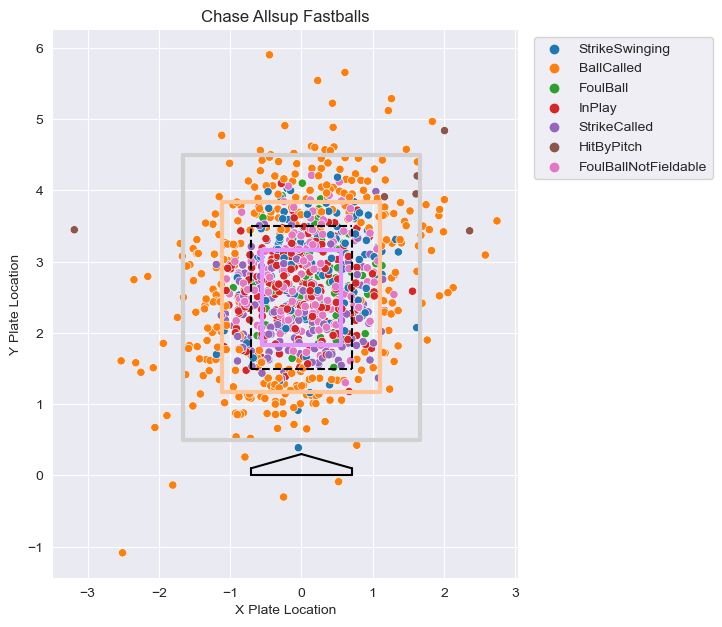

In [51]:
fig = plt.figure(figsize=(6,9))
fig = sns.scatterplot(data=t_bauman, x='PlateLocSide', y='PlateLocHeight', 
                      hue='PitchCall')

draw_sz(ls='k--')
draw_home_plate(False)
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine(left=True, bottom=True)
plt.title('Chase Allsup Fastballs')
plt.xlabel('X Plate Location')
plt.ylabel('Y Plate Location')
plt.show()

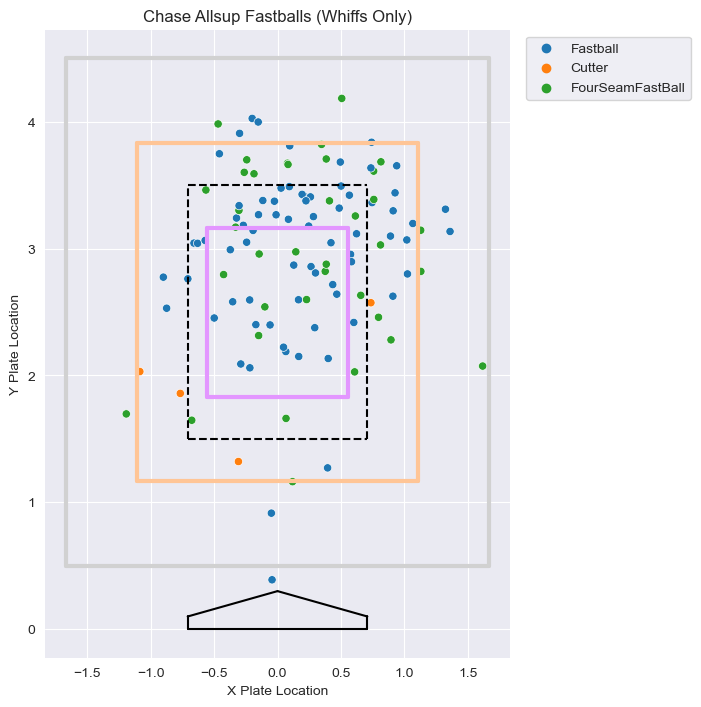

In [52]:
fig = plt.figure(figsize=(6,9))
fig = sns.scatterplot(data=t_bauman[t_bauman['PitchCall'] == 'StrikeSwinging'], x='PlateLocSide', y='PlateLocHeight',
                      hue='TaggedPitchType')

draw_sz(ls='k--')
draw_home_plate(False)
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine(left=True, bottom=True)
plt.title('Chase Allsup Fastballs (Whiffs Only)')
plt.xlabel('X Plate Location')
plt.ylabel('Y Plate Location')
plt.show()